<a href="https://colab.research.google.com/github/RcJetty/Stock-Prediction/blob/main/CA_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install yfinance
! pip install pandas
! pip install plotly
! pip install numpy
! pip install scikit-learn
! pip install tensorflow
! pip install keras

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Conv1D, MaxPooling1D, Flatten, SimpleRNN, GRU, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from itertools import cycle
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.utils import plot_model
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import display, clear_output
import time

Mounted at /content/drive


In [ ]:
nashdaq100 = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]
nashdaq100

Company Ticker             GICS Sector  \
0                  Adobe Inc.   ADBE  Information Technology   
1                         ADP    ADP             Industrials   
2                      Airbnb   ABNB  Consumer Discretionary   
3     Alphabet Inc. (Class A)  GOOGL  Communication Services   
4     Alphabet Inc. (Class C)   GOOG  Communication Services   
..                        ...    ...                     ...   
96   Walgreens Boots Alliance    WBA        Consumer Staples   
97     Warner Bros. Discovery    WBD  Communication Services   
98              Workday, Inc.   WDAY  Information Technology   
99                Xcel Energy    XEL               Utilities   
100                   Zscaler     ZS  Information Technology   

                        GICS Sub-Industry  
0                    Application Software  
1    Human Resource & Employment Services  
2          Hotels, Resorts & Cruise Lines  
3            Interactive Media & Services  
4            Interactive Media & Services  
..                                    ...  
96                            Drug Retail  
97                           Broadcasting  
98                   Application Software  
99                        Multi-Utilities  
100                  Application Software  

[101 rows x 4 columns]

In [ ]:
# Replace '.' with '-' in the 'Ticker' column of the 'nasdaq100' DataFrame
nashdaq100['Ticker'] = nashdaq100['Ticker'].str.replace('.', '-')
# Get unique tickers and convert them to a list
Ticker_list = nashdaq100['Ticker'].unique().tolist()
# Display the list of tickers
Ticker_list

['ADBE',
 'ADP',
 'ABNB',
 'GOOGL',
 'GOOG',
 'AMZN',
 'AMD',
 'AEP',
 'AMGN',
 'ADI',
 'ANSS',
 'AAPL',
 'AMAT',
 'ASML',
 'AZN',
 'TEAM',
 'ADSK',
 'BKR',
 'BIIB',
 'BKNG',
 'AVGO',
 'CDNS',
 'CDW',
 'CHTR',
 'CTAS',
 'CSCO',
 'CCEP',
 'CTSH',
 'CMCSA',
 'CEG',
 'CPRT',
 'CSGP',
 'COST',
 'CRWD',
 'CSX',
 'DDOG',
 'DXCM',
 'FANG',
 'DLTR',
 'DASH',
 'EA',
 'EXC',
 'FAST',
 'FTNT',
 'GEHC',
 'GILD',
 'GFS',
 'HON',
 'IDXX',
 'ILMN',
 'INTC',
 'INTU',
 'ISRG',
 'KDP',
 'KLAC',
 'KHC',
 'LRCX',
 'LIN',
 'LULU',
 'MAR',
 'MRVL',
 'MELI',
 'META',
 'MCHP',
 'MU',
 'MSFT',
 'MRNA',
 'MDLZ',
 'MDB',
 'MNST',
 'NFLX',
 'NVDA',
 'NXPI',
 'ORLY',
 'ODFL',
 'ON',
 'PCAR',
 'PANW',
 'PAYX',
 'PYPL',
 'PDD',
 'PEP',
 'QCOM',
 'REGN',
 'ROP',
 'ROST',
 'SIRI',
 'SBUX',
 'SNPS',
 'TTWO',
 'TMUS',
 'TSLA',
 'TXN',
 'TTD',
 'VRSK',
 'VRTX',
 'WBA',
 'WBD',
 'WDAY',
 'XEL',
 'ZS']

In [ ]:
# Function to calculate Moving Average (MA)
def calculate_ma(df, window=20):
    return df['Close'].rolling(window=window).mean()

In [ ]:
# Function to calculate Relative Strength Index (RSI)
def calculate_rsi(df, window=14):
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / lossZ
    return 100 - (100 / (1 + rs))

In [ ]:
# Function to calculate Moving Average Convergence Divergence (MACD)
def calculate_macd(df, short_window=12, long_window=26):
    short_ema = df['Close'].ewm(span=short_window, min_periods=1).mean()
    long_ema = df['Close'].ewm(span=long_window, min_periods=1).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=9, min_periods=1).mean()
    return macd, signal

In [ ]:
# Function to calculate Stochastic Oscillator
def calculate_stochastic_oscillator(df, window=14):
    lowest_low = df['Low'].rolling(window=window).min()
    highest_high = df['High'].rolling(window=window).max()
    k_percent = ((df['Close'] - lowest_low) / (highest_high - lowest_low)) * 100
    return k_percent

In [ ]:
def main():
    # Define the list of stocks
    stocks = Ticker_list

    # Define the date range
    start_date = '2023-01-01'
    end_date = '2024-01-01'

    top_stocks = []

    for stock in stocks:
        # Load stock data from Yahoo Finance
        df = yf.download(stock)

        # Calculate indicators
        df['RSI'] = calculate_rsi(df)
        df['MACD'], df['MACD Signal'] = calculate_macd(df)
        df['Stochastic Oscillator'] = calculate_stochastic_oscillator(df)
        df['MA'] = calculate_ma(df)

        # Filter top stocks based on indicators
        if (df['RSI'].iloc[-1] > 60) and \
           (df['MACD'].iloc[-1] > df['MACD Signal'].iloc[-1]) and \
           (df['Stochastic Oscillator'].iloc[-1] > 50) and \
           (df['Close'].iloc[-1] > df['MA'].iloc[-1]):
            top_stocks.append(stock)

    Tickers = top_stocks[:3]
    print("\nTop 3 stocks to buy and store:", Tickers)

In [ ]:
if __name__ == "__main__":
    main()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******


Top 3 stocks to buy and store: ['GOOGL', 'GOOG', 'AMD']


In [ ]:
Tickers=['GOOGL', 'GOOG', 'AMD']

In [ ]:
for ticker in Tickers:
    data = yf.download(ticker)
    display(data)

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-08-19    2.502503    2.604104    2.401401    2.511011    2.511011   
2004-08-20    2.527778    2.729730    2.515015    2.710460    2.710460   
2004-08-23    2.771522    2.839840    2.728979    2.737738    2.737738   
2004-08-24    2.783784    2.792793    2.591842    2.624374    2.624374   
2004-08-25    2.626627    2.702703    2.599600    2.652653    2.652653   
...                ...         ...         ...         ...         ...   
2024-04-16  154.190002  155.649994  153.429993  154.399994  154.399994   
2024-04-17  155.619995  157.080002  154.580002  155.470001  155.470001   
2024-04-18  155.339996  156.940002  154.619995  156.009995  156.009995   
2024-04-19  156.199997  156.360001  152.300003  154.089996  154.089996   
2024-04-22  154.110001  156.470001  154.059998  155.250000  155.250000   

               Volume  
Date                   
2004-08-19  893181924  
2004-08-20  456686856  
2004-08-23  365122512  
2004-08-24  304946748  
2004-08-25  183772044  
...               ...  
2024-04-16   20779500  
2024-04-17   21763100  
2024-04-18   19883000  
2024-04-19   32239100  
2024-04-22    9238992  

[4952 rows x 6 columns]

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-08-19    2.490664    2.591785    2.390042    2.499133    2.499133   
2004-08-20    2.515820    2.716817    2.503118    2.697639    2.697639   
2004-08-23    2.758411    2.826406    2.716070    2.724787    2.724787   
2004-08-24    2.770615    2.779581    2.579581    2.611960    2.611960   
2004-08-25    2.614201    2.689918    2.587302    2.640104    2.640104   
...                ...         ...         ...         ...         ...   
2024-04-16  155.639999  157.229996  155.050003  156.000000  156.000000   
2024-04-17  157.190002  158.681000  156.134995  156.880005  156.880005   
2024-04-18  156.925003  158.485001  156.210007  157.460007  157.460007   
2024-04-19  157.750000  157.990005  153.910004  155.720001  155.720001   
2024-04-22  156.009995  158.149994  155.660004  156.850006  156.850006   

               Volume  
Date                   
2004-08-19  897427216  
2004-08-20  458857488  
2004-08-23  366857939  
2004-08-24  306396159  
2004-08-25  184645512  
...               ...  
2024-04-16   15413200  
2024-04-17   16237800  
2024-04-18   14016100  
2024-04-19   20063900  
2024-04-22    6213684  

[4952 rows x 6 columns]

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
1980-03-17    0.000000    3.302083    3.125000    3.145833    3.145833   
1980-03-18    0.000000    3.125000    2.937500    3.031250    3.031250   
1980-03-19    0.000000    3.083333    3.020833    3.041667    3.041667   
1980-03-20    0.000000    3.062500    3.010417    3.010417    3.010417   
1980-03-21    0.000000    3.020833    2.906250    2.916667    2.916667   
...                ...         ...         ...         ...         ...   
2024-04-16  162.279999  164.880005  161.669998  163.460007  163.460007   
2024-04-17  163.970001  164.449997  153.880005  154.020004  154.020004   
2024-04-18  155.509995  156.960007  152.320007  155.080002  155.080002   
2024-04-19  151.589996  154.250000  145.289993  146.639999  146.639999   
2024-04-22  148.190002  149.889999  145.630005  146.949997  146.949997   

              Volume  
Date                  
1980-03-17    219600  
1980-03-18    727200  
1980-03-19    295200  
1980-03-20    159600  
1980-03-21    130800  
...              ...  
2024-04-16  55302100  
2024-04-17  75909000  
2024-04-18  52669800  
2024-04-19  71232500  
2024-04-22  25350265  

[11118 rows x 6 columns]

In [ ]:
for ticker in Tickers:
    # Download data from Yahoo Finance
    data = yf.download(ticker)

    # Create OHLC chart using Plotly
    fig = go.Figure(data=go.Ohlc(x=data.index,
                                  open=data['Open'],
                                  high=data['High'],
                                  low=data['Low'],
                                  close=data['Close'],
                                  hovertext=data.apply(lambda row: f"Date: {row.name}<br>Open: {row['Open']}<br>High: {row['High']}<br>Low: {row['Low']}<br>Close: {row['Close']}", axis=1)))
    # Customize layout
    fig.update_layout(title=f'{ticker} OHLC Chart',
                      xaxis_title='Date',
                      yaxis_title='Stock Price',
                      xaxis_rangeslider_visible=False)
    # Display the chart
    fig.show()

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


In [ ]:
Tickers=['GOOGL', 'GOOG', 'AMD']
# Loop through each ticker
for ticker in Tickers:
    # Download data for the ticker
    data = yf.download(ticker, start='2009-01-01', end='2019-01-01')

    # Save the DataFrame to a CSV file in Google Drive
    data.to_csv(f'/content/drive/My Drive/{ticker}_data.csv')


Mounted at /content/drive


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
scaler = StandardScaler()

In [ ]:
time_step = 15

In [ ]:
# Function to create dataset
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data.iloc[i:(i+time_step)].values)
        y.append(data.iloc[i+time_step].values)
    return np.array(X), np.array(y)

In [ ]:
# Evaluation metrics
def print_evaluation_metrics(y_true, y_pred, prefix, ticker):
  rmse = math.sqrt(mean_squared_error(y_true, y_pred))
  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  evs = explained_variance_score(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  print(ticker)
  print(f"{prefix} data RMSE: {rmse}")
  print(f"{prefix} data MSE: {mse}")
  print(f"{prefix} data MAE: {mae}")
  print(f"{prefix} data explained variance regression score: {evs}")
  print(f"{prefix} data R2 score: {r2}")
  print("-------------------------------------------------------------------------------------")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 15, 128)           512       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 33537 (131.00 KB)
Trainable params: 33537 (131.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


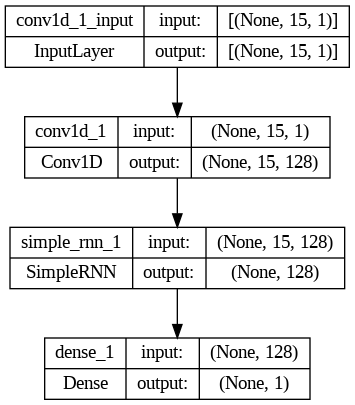

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, SimpleRNN, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

model1 = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', padding='same', input_shape=(15, 1)),
    SimpleRNN(128, kernel_regularizer=l2(0.01)),
    Dense(1)
])

model1.compile(loss='mean_squared_error', optimizer='adam')
model1.build(input_shape=(None, 15, 1))  # Build the model

model1.summary()
plot_model(model1, show_shapes=True, show_layer_names=True)


In [ ]:
plot_data = []
for ticker in Tickers:
    data = yf.download(ticker, start='2009-01-01', end='2019-01-01')

    # Process data
    data.columns = data.columns.str.lower()
    data = data.dropna()

    r_data = data[['close']].copy()
    r_data.reset_index(drop=True, inplace= True)

    # Scaling the data
    data_scaled = r_data.copy()
    data_scaled['close'] = scaler.fit_transform(data_scaled[['close']])

    # Split data into train and test sets
    training_size = int(len(data_scaled) * 0.80)
    test_size = len(data_scaled) - training_size
    train_data, test_data = data_scaled.iloc[0:training_size], data_scaled.iloc[training_size:]

    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # reshape input to be [samples, time steps, features] which is required for RNN
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

    # Train  model1
    model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=1,verbose=1)
    # Make predictions
    # Lets Do the prediction and check performance metrics
    train_predict=model1.predict(X_train)
    test_predict=model1.predict(X_test)
    # Perform inverse transformation
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    original_ytrain = scaler.inverse_transform(y_train)
    original_ytest = scaler.inverse_transform(y_test)

    # Evaluation metrices RMSE and MAE
    print_evaluation_metrics(original_ytrain, train_predict, "Train",ticker)
    print_evaluation_metrics(original_ytest, test_predict, "Test",ticker)

    #visualization

    original_returns = data['close'].values
    train_indices = range(len(train_predict))
    test_indices = range(len(train_predict), len(train_predict) + len(test_predict))

    # Create traces
    trace_original_CP = go.Scatter(x=data.index, y=original_returns, mode='lines', name='Original Closing Price')
    trace_train_predicted_CP = go.Scatter(x=data.index[train_indices], y=train_predict.flatten(), mode='lines', name='Train predicted Closing Price')
    trace_test_predicted_CP = go.Scatter(x=data.index[test_indices], y=test_predict.flatten(), mode='lines', name='Test predicted Closing Price')

    # Create layout
    layout = go.Layout(title=f'{ticker} Original Closing Price vs Predicted Closing Price',
                      xaxis=dict(title='Date'),
                      yaxis=dict(title='Closing Price'))

    # Create figure
    fig = go.Figure(data=[trace_original_CP, trace_train_predicted_CP, trace_test_predicted_CP], layout=layout)

    # Show plot
    fig.show()
    plot_data.append(fig)

# # Save plots as HTML files in Google Drive
# for i, plot in enumerate(plot_data):
#     plot.write_html(f"/content/drive/My Drive/CNNRNN_Close/plot_BiRNN_CP{i}.html")

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
1996/1996 [==============================] - 10s 5ms/step - loss: 0.0038 - val_loss: 0.0314
Epoch 2/10
1996/1996 [==============================] - 8s 4ms/step - loss: 0.0164 - val_loss: 0.1579
Epoch 3/10
1996/1996 [==============================] - 10s 5ms/step - loss: 0.0040 - val_loss: 0.0230
Epoch 4/10
1996/1996 [==============================] - 10s 5ms/step - loss: 0.0029 - val_loss: 0.0295
Epoch 5/10
1996/1996 [==============================] - 8s 4ms/step - loss: 0.0025 - val_loss: 0.0277
Epoch 6/10
1996/1996 [==============================] - 11s 5ms/step - loss: 0.0023 - val_loss: 0.0361
Epoch 7/10
1996/1996 [==============================] - 10s 5ms/step - loss: 0.0025 - val_loss: 0.0176
Epoch 8/10
1996/1996 [==============================] - 10s 5ms/step - loss: 0.0395 - val_loss: 0.3005
Epoch 9/10
1996/1996 [==============================] - 10s 5ms/step - loss: 0.0074 - val_loss: 0.1490
Epoch 10/10
16/16 [==============================] - 0s 3ms/step
GOOGL
Trai

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
1996/1996 [==============================] - 10s 5ms/step - loss: 0.0054 - val_loss: 0.0201
Epoch 2/10
1996/1996 [==============================] - 11s 5ms/step - loss: 0.0042 - val_loss: 0.0364
Epoch 3/10
1996/1996 [==============================] - 11s 6ms/step - loss: 0.0038 - val_loss: 0.0759
Epoch 4/10
1996/1996 [==============================] - 11s 5ms/step - loss: 0.0022 - val_loss: 0.1375
Epoch 5/10
1996/1996 [==============================] - 10s 5ms/step - loss: 0.0099 - val_loss: 0.2184
Epoch 6/10
1996/1996 [==============================] - 10s 5ms/step - loss: 0.0022 - val_loss: 0.0559
Epoch 7/10
1996/1996 [==============================] - 11s 5ms/step - loss: 0.0018 - val_loss: 0.0782
Epoch 8/10
1996/1996 [==============================] - 11s 5ms/step - loss: 0.0019 - val_loss: 0.0797
Epoch 9/10
1996/1996 [==============================] - 11s 5ms/step - loss: 0.0018 - val_loss: 0.0990
Epoch 10/10
16/16 [==============================] - 0s 5ms/step
GOOG
Tra

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
1996/1996 [==============================] - 11s 5ms/step - loss: 0.0299 - val_loss: 1.0607
Epoch 2/10
1996/1996 [==============================] - 12s 6ms/step - loss: 0.0123 - val_loss: 0.7860
Epoch 3/10
1996/1996 [==============================] - 12s 6ms/step - loss: 0.0055 - val_loss: 0.7863
Epoch 4/10
1996/1996 [==============================] - 11s 6ms/step - loss: 0.0031 - val_loss: 0.4744
Epoch 5/10
1996/1996 [==============================] - 10s 5ms/step - loss: 0.0026 - val_loss: 2.4121
Epoch 6/10
1996/1996 [==============================] - 11s 6ms/step - loss: 0.0025 - val_loss: 0.8454
Epoch 7/10
1996/1996 [==============================] - 11s 6ms/step - loss: 0.0027 - val_loss: 0.6218
Epoch 8/10
1996/1996 [==============================] - 11s 6ms/step - loss: 0.0027 - val_loss: 0.5576
Epoch 9/10
1996/1996 [==============================] - 10s 5ms/step - loss: 0.0023 - val_loss: 0.5551
Epoch 10/10
16/16 [==============================] - 0s 3ms/step
AMD
Trai

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 128)           512       
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 132225 (516.50 KB)
Trainable params: 132225 (516.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


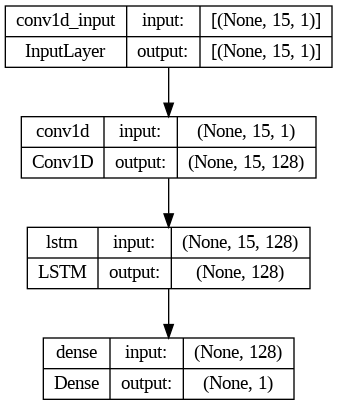

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

model2 = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', padding='same', input_shape=(15, 1)),
    LSTM(128, kernel_regularizer=l2(0.01)),
    Dense(1)
])

model2.compile(loss='mean_squared_error', optimizer='adam')
model2.build(input_shape=(None, 15, 1))  # Build the model

model2.summary()
plot_model(model2, show_shapes=True, show_layer_names=True)


In [ ]:
plot_data = []
for ticker in Tickers:
    data = yf.download(ticker, start='2009-01-01', end='2019-01-01')

    # Process data
    data.index.names = ['date']
    data.columns = data.columns.str.lower()
    data = data.dropna()

    # Scale features
    r_data = data[['close']].copy()
    r_data.reset_index(drop=True, inplace= True)
    data_scaled = r_data.copy()
    data_scaled['close'] = scaler.fit_transform(data_scaled[['close']])

    # Split data into train and test sets
    training_size = int(len(data_scaled) * 0.80)
    test_size = len(data_scaled) - training_size
    train_data, test_data = data_scaled.iloc[0:training_size], data_scaled.iloc[training_size:]

    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

    # Train  model2
    model2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=1,verbose=1)
    # Make predictions
    # Lets Do the prediction and check performance metrics
    train_predict=model2.predict(X_train)
    test_predict=model2.predict(X_test)
    # Perform inverse transformation
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    original_ytrain = scaler.inverse_transform(y_train)
    original_ytest = scaler.inverse_transform(y_test)

    # Evaluation metrices RMSE and MAE
    print_evaluation_metrics(original_ytrain, train_predict, "Train",ticker)
    print_evaluation_metrics(original_ytest, test_predict, "Test",ticker)

    #visualization

    original_returns = data['close'].values
    train_indices = range(len(train_predict))
    test_indices = range(len(train_predict), len(train_predict) + len(test_predict))

    # Create traces
    trace_original_CP = go.Scatter(x=data.index, y=original_returns, mode='lines', name='Original Closing Price')
    trace_train_predicted_CP = go.Scatter(x=data.index[train_indices], y=train_predict.flatten(), mode='lines', name='Train predicted Closing Price')
    trace_test_predicted_CP = go.Scatter(x=data.index[test_indices], y=test_predict.flatten(), mode='lines', name='Test predicted Closing Price')

    # Create layout
    layout = go.Layout(title=f'{ticker} Original Closing Price vs Predicted Closing Price',
                      xaxis=dict(title='Date'),
                      yaxis=dict(title='Closing Price'))

    # Create figure
    fig = go.Figure(data=[trace_original_CP, trace_train_predicted_CP, trace_test_predicted_CP], layout=layout)

    # Show plot
    fig.show()
    plot_data.append(fig)


# # Save plots as HTML files in Google Drive
# for i, plot in enumerate(plot_data):
#     plot.write_html(f"/content/drive/My Drive/CNNRNN_Close/plot_BiLSTM_CP{i}.html")

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
1996/1996 [==============================] - 34s 17ms/step - loss: 0.0049 - val_loss: 0.1084
Epoch 2/10
1996/1996 [==============================] - 29s 14ms/step - loss: 0.0034 - val_loss: 0.0305
Epoch 3/10
1996/1996 [==============================] - 29s 15ms/step - loss: 0.0033 - val_loss: 0.0115
Epoch 4/10
1996/1996 [==============================] - 28s 14ms/step - loss: 0.0032 - val_loss: 0.0070
Epoch 5/10
1996/1996 [==============================] - 28s 14ms/step - loss: 0.0028 - val_loss: 0.0649
Epoch 6/10
1996/1996 [==============================] - 28s 14ms/step - loss: 0.0028 - val_loss: 0.0187
Epoch 7/10
1996/1996 [==============================] - 28s 14ms/step - loss: 0.0026 - val_loss: 0.0420
Epoch 8/10
1996/1996 [==============================] - 28s 14ms/step - loss: 0.0026 - val_loss: 0.0159
Epoch 9/10
1996/1996 [==============================] - 29s 15ms/step - loss: 0.0022 - val_loss: 0.0152
Epoch 10/10
16/16 [==============================] - 0s 9ms/step

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
1996/1996 [==============================] - 30s 15ms/step - loss: 0.0021 - val_loss: 0.0184
Epoch 2/10
1996/1996 [==============================] - 30s 15ms/step - loss: 0.0020 - val_loss: 0.0087
Epoch 3/10
1996/1996 [==============================] - 29s 14ms/step - loss: 0.0018 - val_loss: 0.0516
Epoch 4/10
1996/1996 [==============================] - 28s 14ms/step - loss: 0.0019 - val_loss: 0.0262
Epoch 5/10
1996/1996 [==============================] - 28s 14ms/step - loss: 0.0018 - val_loss: 0.0167
Epoch 6/10
1996/1996 [==============================] - 30s 15ms/step - loss: 0.0018 - val_loss: 0.0100
Epoch 7/10
1996/1996 [==============================] - 29s 14ms/step - loss: 0.0017 - val_loss: 0.0240
Epoch 8/10
1996/1996 [==============================] - 29s 14ms/step - loss: 0.0016 - val_loss: 0.0080
Epoch 9/10
1996/1996 [==============================] - 29s 14ms/step - loss: 0.0016 - val_loss: 0.0121
Epoch 10/10
16/16 [==============================] - 0s 9ms/step

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
1996/1996 [==============================] - 30s 15ms/step - loss: 0.0024 - val_loss: 0.1993
Epoch 2/10
1996/1996 [==============================] - 30s 15ms/step - loss: 0.0025 - val_loss: 0.1778
Epoch 3/10
1996/1996 [==============================] - 30s 15ms/step - loss: 0.0023 - val_loss: 0.1045
Epoch 4/10
1996/1996 [==============================] - 32s 16ms/step - loss: 0.0022 - val_loss: 0.2785
Epoch 5/10
1996/1996 [==============================] - 31s 15ms/step - loss: 0.0025 - val_loss: 0.1207
Epoch 6/10
1996/1996 [==============================] - 32s 16ms/step - loss: 0.0023 - val_loss: 0.1649
Epoch 7/10
1996/1996 [==============================] - 31s 15ms/step - loss: 0.0022 - val_loss: 0.2435
Epoch 8/10
1996/1996 [==============================] - 31s 15ms/step - loss: 0.0022 - val_loss: 0.0960
Epoch 9/10
1996/1996 [==============================] - 31s 16ms/step - loss: 0.0022 - val_loss: 0.0990
Epoch 10/10
16/16 [==============================] - 0s 9ms/step

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 15, 128)           512       
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 99713 (389.50 KB)
Trainable params: 99713 (389.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


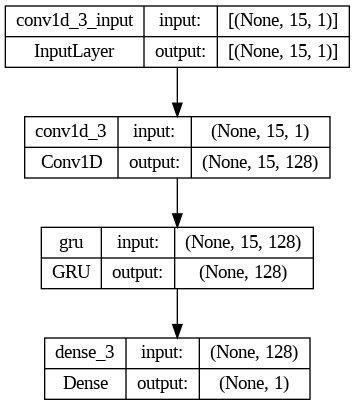

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, SimpleRNN, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

model3 = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', padding='same', input_shape=(15, 1)),
    GRU(128, kernel_regularizer=l2(0.01)),
    Dense(1)
])

model3.compile(loss='mean_squared_error', optimizer='adam')
model3.build(input_shape=(None, 15, 1))  # Build the model

model3.summary()
plot_model(model3, show_shapes=True, show_layer_names=True)

In [ ]:
plot_data = []
for ticker in Tickers:
    data = yf.download(ticker, start='2009-01-01', end='2019-01-01')

    # Process data
    data.index.names = ['date']
    data.columns = data.columns.str.lower()
    data = data.dropna()

    # Scale features
    r_data = data[['close']].copy()
    r_data.reset_index(drop=True, inplace= True)
    data_scaled = r_data.copy()
    data_scaled['close'] = scaler.fit_transform(data_scaled[['close']])

    # Split data into train and test sets
    training_size = int(len(data_scaled) * 0.80)
    test_size = len(data_scaled) - training_size
    train_data, test_data = data_scaled.iloc[0:training_size], data_scaled.iloc[training_size:]

    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

    # Train  model3
    model3.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=1,verbose=1)
    # Make predictions
    # Lets Do the prediction and check performance metrics
    train_predict=model3.predict(X_train)
    test_predict=model3.predict(X_test)
    # Perform inverse transformation
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    original_ytrain = scaler.inverse_transform(y_train)
    original_ytest = scaler.inverse_transform(y_test)

    # Evaluation metrices
    print_evaluation_metrics(original_ytrain, train_predict, "Train",ticker)
    print_evaluation_metrics(original_ytest, test_predict, "Test",ticker)

    #visualization

    original_returns = data['close'].values
    train_indices = range(len(train_predict))
    test_indices = range(len(train_predict), len(train_predict) + len(test_predict))

    # Create traces
    trace_original_CP = go.Scatter(x=data.index, y=original_returns, mode='lines', name='Original Closing Price')
    trace_train_predicted_CP = go.Scatter(x=data.index[train_indices], y=train_predict.flatten(), mode='lines', name='Train predicted Closing Price')
    trace_test_predicted_CP = go.Scatter(x=data.index[test_indices], y=test_predict.flatten(), mode='lines', name='Test predicted Closing Price')

    # Create layout
    layout = go.Layout(title=f'{ticker} Original Closing Price vs Predicted Closing Price',
                      xaxis=dict(title='Date'),
                      yaxis=dict(title='Closing Price'))

    # Create figure
    fig = go.Figure(data=[trace_original_CP, trace_train_predicted_CP, trace_test_predicted_CP], layout=layout)

    # Show plot
    fig.show()
    plot_data.append(fig)

# Save plots as HTML files in Google Drive
for i, plot in enumerate(plot_data):
    plot.write_html(f"/content/drive/My Drive/CNNRNN_Close/plot_BiGRU_CP{i}.html")

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
1996/1996 [==============================] - 25s 11ms/step - loss: 0.0565 - val_loss: 0.0099
Epoch 2/10
1996/1996 [==============================] - 22s 11ms/step - loss: 0.0060 - val_loss: 0.0151
Epoch 3/10
1996/1996 [==============================] - 21s 11ms/step - loss: 0.0045 - val_loss: 0.0542
Epoch 4/10
1996/1996 [==============================] - 22s 11ms/step - loss: 0.0036 - val_loss: 0.0134
Epoch 5/10
1996/1996 [==============================] - 23s 11ms/step - loss: 0.0036 - val_loss: 0.0254
Epoch 6/10
1996/1996 [==============================] - 22s 11ms/step - loss: 0.0033 - val_loss: 0.0088
Epoch 7/10
1996/1996 [==============================] - 23s 11ms/step - loss: 0.0029 - val_loss: 0.0556
Epoch 8/10
1996/1996 [==============================] - 22s 11ms/step - loss: 0.0029 - val_loss: 0.0307
Epoch 9/10
1996/1996 [==============================] - 21s 11ms/step - loss: 0.0026 - val_loss: 0.0202
Epoch 10/10
16/16 [==============================] - 0s 6ms/step

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
1996/1996 [==============================] - 26s 13ms/step - loss: 0.0025 - val_loss: 0.0183
Epoch 2/10
1996/1996 [==============================] - 25s 13ms/step - loss: 0.0023 - val_loss: 0.0248
Epoch 3/10
1996/1996 [==============================] - 23s 12ms/step - loss: 0.0024 - val_loss: 0.0310
Epoch 4/10
1996/1996 [==============================] - 25s 12ms/step - loss: 0.0029 - val_loss: 0.0257
Epoch 5/10
1996/1996 [==============================] - 25s 12ms/step - loss: 0.0022 - val_loss: 0.0193
Epoch 6/10
1996/1996 [==============================] - 22s 11ms/step - loss: 0.0022 - val_loss: 0.0235
Epoch 7/10
1996/1996 [==============================] - 25s 13ms/step - loss: 0.0020 - val_loss: 0.0059
Epoch 8/10
1996/1996 [==============================] - 24s 12ms/step - loss: 0.0022 - val_loss: 0.0140
Epoch 9/10
1996/1996 [==============================] - 26s 13ms/step - loss: 0.0020 - val_loss: 0.0645
Epoch 10/10
16/16 [==============================] - 0s 5ms/step

[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
1996/1996 [==============================] - 26s 13ms/step - loss: 0.0028 - val_loss: 0.1703
Epoch 2/10
1996/1996 [==============================] - 26s 13ms/step - loss: 0.0027 - val_loss: 0.2213
Epoch 3/10
1996/1996 [==============================] - 26s 13ms/step - loss: 0.0025 - val_loss: 0.1227
Epoch 4/10
1996/1996 [==============================] - 26s 13ms/step - loss: 0.0026 - val_loss: 0.2465
Epoch 5/10
1996/1996 [==============================] - 27s 13ms/step - loss: 0.0025 - val_loss: 0.1857
Epoch 6/10
1996/1996 [==============================] - 25s 13ms/step - loss: 0.0024 - val_loss: 0.2072
Epoch 7/10
1996/1996 [==============================] - 27s 14ms/step - loss: 0.0024 - val_loss: 0.2052
Epoch 8/10
1996/1996 [==============================] - 27s 14ms/step - loss: 0.0024 - val_loss: 0.2391
Epoch 9/10
1996/1996 [==============================] - 26s 13ms/step - loss: 0.0024 - val_loss: 0.2290
Epoch 10/10
16/16 [==============================] - 0s 10ms/ste